# Perceptron

First you will implement three different ways of spliting the data / updating weights (online, mini-batch and full-batch) :

+ Online : The data is split every sample and each update of the weigths is based on one sample.
+ Mini-batch : The data is split every l (l  is the length of the mini-batch), The weigths update is based on l samples.
+ Full-batch : The batch is all the training samples.

Second you have to implement the loss and compute the gradients, the you'll use the grads computed to update the weights.

Finally, you will visualize the results and comment them.

In [96]:
# Run some setup code for this notebook.

import numpy as np
from data_utils import load_IRIS
import matplotlib.pyplot as plt

# make figures appear inline
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


colors_surfaces = ['#88E2EA', '#FFE1BB', '#D4F3CD']
colors_points = ['blue', 'red', 'green']

axes_labels = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Introduction to Perceptron

In machine learning, the perceptron is an algorithm for supervised learning of binary classifiers. A binary classifier is a function which can decide whether or not an input, represented by a vector of numbers, belongs to some specific class. It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. More information about perceptron [here](https://en.wikipedia.org/wiki/Perceptron).

The Perceptron is a two class algorithm, with class labels $c_1 = -1$, $c_2 = 1$. This algorithm will find a set of weights only if the problem is linearly separable. When the problem is not linear separable the perceptron is the non-convergence. 

We will consider a set of data $X$ with length $n$ and $d$ attributs, where $\mathbf{x_i}$ for $i := 1...n$ and $\mathbf{x_i} \in R^d$ is a instance of X, that comes with a label $c \in \{c_1, c_2\}$ in the form of a vector :

$$
\begin{array}{c}
\mathbf{x_i} = [x_{i1},x_{i2},...,x_{id}]
\end{array}
$$

As we see before the perceptron is a linear classifier between two classes, so we will load the iris dataset with two classes. We load two sets of data :

- The training data will allow us to train our model
- The test data will be usefull to verify our model with unkown data, wich should be the performance expected in real world.

In [97]:
import numpy as np

from sklearn import datasets
from sklearn.utils import shuffle

def load_IRIS(p_train=0.7, p_test=0.3, n_classes=2):
    iris = datasets.load_iris()

    X, y = iris.data, iris.target
    idx = np.array(y == 0) | np.array(y == 2) # class 0 or class 2
    X = X[idx, :]
    y = y[idx]

    y[y == 0] = 1 # convert things so they match the Perceptron
    y[y == 2] = -1

    X, y = shuffle(X, y, random_state=1331)

    n = X.shape[0]


    n_train = int(p_train*n)

    X_train = X[:n_train, :]
    y_train = y[:n_train]
    X_test = X[n_train:, :]
    y_test = y[n_train:]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_IRIS(p_train=0.7, p_test=0.3, n_classes=2)

# As a sanity check, we print out the size of the training, the validation and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (70, 4)
Training labels shape:  (70,)
Test data shape:  (30, 4)
Test labels shape:  (30,)


The Iris dataset come with 4 attributs (Sepal Length, Sepal Width, Petal Length, Petal Width), for visualization purpose we will only keep two of them, we arbitrary choose the first two.

Bellow we show our training data : 

<Figure size 1500x1000 with 0 Axes>

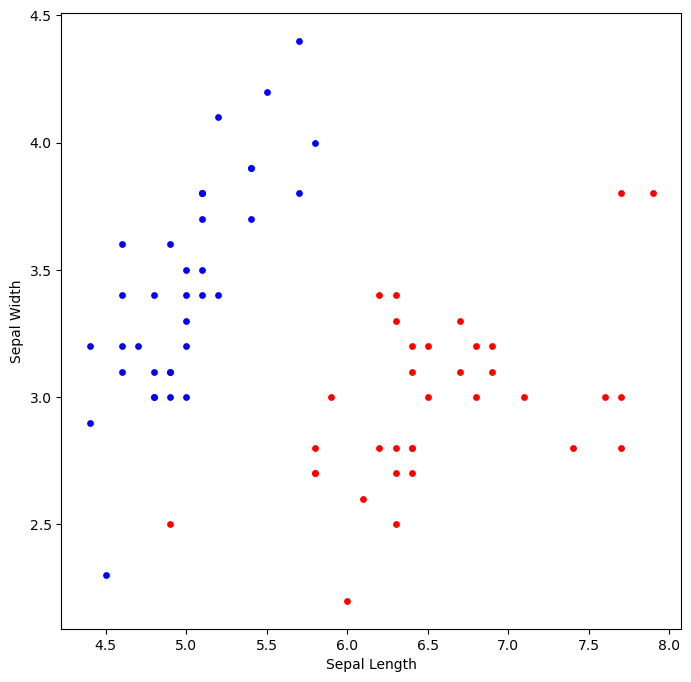

In [98]:
attribut_1 = 0
attribut_2 = 1

plt.clf()
fig = plt.figure(figsize=(8.0, 8.0))

x_train_1 = np.array([X_train[:,attribut_1], X_train[:,attribut_2]]).T

coord_plot_x_class_1 = x_train_1[y_train == 1, 0]
coord_plot_y_class_1 = x_train_1[y_train == 1, 1]

coord_plot_x_class_2 = x_train_1[y_train == -1, 0]
coord_plot_y_class_2 = x_train_1[y_train == -1, 1]

plt.scatter(coord_plot_x_class_1, coord_plot_y_class_1, s=15, color=colors_points[0])
plt.scatter(coord_plot_x_class_2, coord_plot_y_class_2, s=15, color=colors_points[1])

plt.xlabel(axes_labels[attribut_1])
plt.ylabel(axes_labels[attribut_2]);



For notation convinience we will consider that $\mathbf{x_i}$ is the augmented $d + 1$ dimensional vector, where the $d + 1$ dimension corresponds to the bias term and is set to 1, thus:

$$
\begin{array}{c}
\mathbf{x_i} = [x_{i1},x_{i2},...,x_{id}, 1]
\end{array}
$$

Remember that perceptron learns a set of weights
$$
\begin{array}{c}
\mathbf{w_t} = (w1,..., wd, w_{d+1})
\end{array}
$$

and using these weights produces the thresholded output
$$
\begin{array}{c}
sign(\mathbf{x_i}\mathbf{w_t})
\end{array}
$$

In [99]:
from perceptron import perceptron

# We choose the first set of atributs
X_train_2_attri = np.array([X_train[:,attribut_1], X_train[:,attribut_2]]).T
X_test_2_attri = np.array([X_test[:,attribut_1], X_test[:,attribut_2]]).T

# adding the bias term
X_train_with_bias = np.column_stack((X_train_2_attri, np.ones(X_train_2_attri.shape[0])))
X_test_with_bias = np.column_stack((X_test_2_attri, np.ones(X_test_2_attri.shape[0])))

_, D = X_train_with_bias.shape
# D = X_train_with_bias.shape[1]

# Initializing the perceptron
np.random.seed(525)
model = perceptron(D)

# The choice of the batch

Open the file `perceptron.py` and look at the method `perceptron.train`. This function will train your model for a given number of epochs. 


## Online

In online, you split the data every sample so if the training set has a length n=5 the training data will be a list of length equal to n, in this exemple would be of length 5. The batch size is equal to one in this case.

Verify if your implementation is correct in the online case.

In [100]:
# go to perceptron.train and implement online
training_data, training_labels = model.train(X_train_with_bias, y_train,
                                             num_epochs=0, batch_size=1)

correct_shapes_data = [True for s in training_data if s.shape == (1,3)]
correct_shapes_labels = [True for s in training_labels if s.shape == (1,)]

if not (len(training_data) and len(training_labels)):
    print("You have to implement online section first.")
else:
    if len(correct_shapes_data) == X_train_with_bias.shape[0]\
        and len(correct_shapes_labels) == y_train.shape[0]:
        print("Great! Your implementation of online section seems good !")
    else:
        print("Bad news! Your implementation of online section seems wrong !")

Great! Your implementation of online section seems good !


## Full-batch

In full-batch, you don't split the data, you give it all in once. If the training set has a length n=5 the training data will be a list of length equal to 1 because we take all the data in once. The batch size is equal to the number of samples in training.

Verify if your implementation is correct in the full-batch case.

In [101]:
# go to perceptron.train and implement Full-batch
training_data, training_labels = model.train(X_train_with_bias, y_train,
                num_epochs=0, batch_size=X_train_with_bias.shape[0])

correct_shapes_data = [True for s in training_data if s.shape == X_train_with_bias.shape]
correct_shapes_labels = [True for s in training_labels if s.shape == y_train.shape]

if not (len(training_data) and len(training_labels)):
    print("You have to implement full_batch section first.")
else:
    if len(correct_shapes_data) == 1 and len(correct_shapes_labels) == 1:
        print("Great! Your implementation of full_batch section seems good !")
    else:
        print("Bad news! Your implementation of full_batch section seems wrong !")

Great! Your implementation of full_batch section seems good !


## Mini-batch

In mini-batch, you split the data into sets of a given batch-size. If the training set has a length n=10 and the batch-size = 2 the training data will be a list of length equal to 5.

Verify if your implementation is correct in the mini-batch case.

In [102]:
# go to perceptron.train and implement Mini-batch
training_data, training_labels = model.train(X_train_with_bias, y_train,
                num_epochs=0, batch_size=10)

correct_shapes_data = [True for s in training_data if s.shape == (10,3)]
correct_shapes_labels = [True for s in training_labels if s.shape == (10,)]

if not (len(training_data) and len(training_labels)):
    print("You have to implement mini_batch section first.")
else:
    if len(correct_shapes_data) == 7 and len(correct_shapes_labels) == 7:
        print("Great! Your implementation of mini_batch section seems good !")
    else:
        print("Bad news! Your implementation of mini_batch section seems wrong !")

Great! Your implementation of mini_batch section seems good !


# Forward pass: compute scores

Open the file `perceptron.py` and look at the method `perceptron.loss`. This function takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

Remember the scores are computed by $sign(\mathbf{x_i}\mathbf{w_t})$

In [103]:
# go to the loss method and implement scores part
scores = model.loss(X_train_with_bias)

if scores is None:
    print("You have to implement scores first.")
else:
    if not np.sum(scores):
        print("Great! Your implementation of scores seems good !")
    else:
        print("Bad news! Your implementation of scores seems wrong !")

Great! Your implementation of scores seems good !


# Forward pass: compute loss

In the same function, implement the second part that computes the data loss.

The error function of perceptron is:

$$
\begin{array}{c}
E({\bf w}) = -\sum_{{\bf x_i} \in M} ({\mathbf x_i}{\bf w}) y_i
\end{array}
$$
where M is the set of missclassified instances and $y_i$ is the class associated to the sample $i$.

In [104]:
# go to the loss method and implement loss part
loss, _ = model.loss(X_train_with_bias, y_train)
print(loss)
if loss is None:
    print("You have to implement loss first.")
else:
    if np.abs(loss - 5e-05) < 1e-5:
        print("Great! Your loss implementation seems good !")
    else:
        print("Bad news! Your loss implementation seems wrong !")

5.0230002732462347e-05
Great! Your loss implementation seems good !


# Backward pass: compute gradients

In the same function, implement the third part that computes the gradients.

The gradient of $E(w)$ is: 

$$
\begin{array}{c}
\nabla E({\bf w})=\sum_{{\bf x_i} \in M} {\bf x_i} y_i = -\mathbf{x}^T(y - sign(\mathbf{x}\mathbf{w}))
\end{array}
$$

In [105]:
# go to the loss method and implement grads part
_, grads = model.loss(X_train_with_bias, y_train)
print(grads)

correct_grads = np.array([[9.], [4.6], [2.]])

if grads == {}:
    print("You have to implement grads first.")
else:
    if np.sum(np.abs(correct_grads - grads['W'])) < 1e-7:
        print("Great! Your computation of gradients seems good !")
    else:
        print("Bad news! Your computation of gradients seems wrong !")

{'W': array([[9. ],
       [4.6],
       [2. ]])}
Great! Your computation of gradients seems good !


# Backward pass: update 

The gradient descent direction is $-\nabla E({\bf w}) = \mathbf{x}^T(y - sign(\mathbf{x}\mathbf{w}))$ and we update the weight
vector w in the gradient descent direction by $\Delta {\bf w} = - \alpha\nabla E({\bf w})$, thus:

$$
\begin{array}{c}
{\bf w} \leftarrow {\bf w} + \Delta {\bf w} = {\bf w} +  \alpha \mathbf{x}^T(y - sign(\mathbf{x}\mathbf{w}))
\end{array}
$$
where $\alpha$ is the learning rate.


In [106]:
# we re-initialize a new model here to allow you to test several times 
np.random.seed(132)
model = perceptron(D)

# go to perceptron.train and implement the update
_ = model.train(X_train_with_bias, y_train,
                num_epochs=1, batch_size=1)

correct_params = np.array([[-0.01645479], [0.02472949], [0.00404943]])

if np.sum(np.abs(correct_params - model.params['W'])) < 1e-7:
    print("Great! Your update seems to work !")
else:
    print("Bad news! Your update does not seem to work !")

Great! Your update seems to work !


# Training
Now that our perceptron is set up, you have to implement `perceptron.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains. This method should not be very hard to implement, think about what you have already done and what this function should do !


We will train the perceptron for the three batch versions you have implemented before for 100 epochs.

In [107]:
n_epochs = 100

# initialise and tain model with online batching
np.random.seed(132)
online_model = perceptron(D)
online_history = online_model.train(X_train_with_bias, y_train,
                             num_epochs=n_epochs, batch_size=1)

# initialise and tain model with full-batch 
np.random.seed(132)
full_batch_model = perceptron(D)
full_batch_history = full_batch_model.train(X_train_with_bias, y_train,
                             num_epochs=n_epochs, batch_size=70)

# initialise and tain model with mini-batch (mini batch-size = 10 by default)
np.random.seed(132)
mini_batch_model = perceptron(D)
mini_batch_history = mini_batch_model.train(X_train_with_bias, y_train,
                                num_epochs=n_epochs, batch_size=10)


### Visualisation of the loss

Bellow we plot the loss for the three types of updating we are using, we ask you to describe/comment the plots.

<Figure size 1500x1000 with 0 Axes>

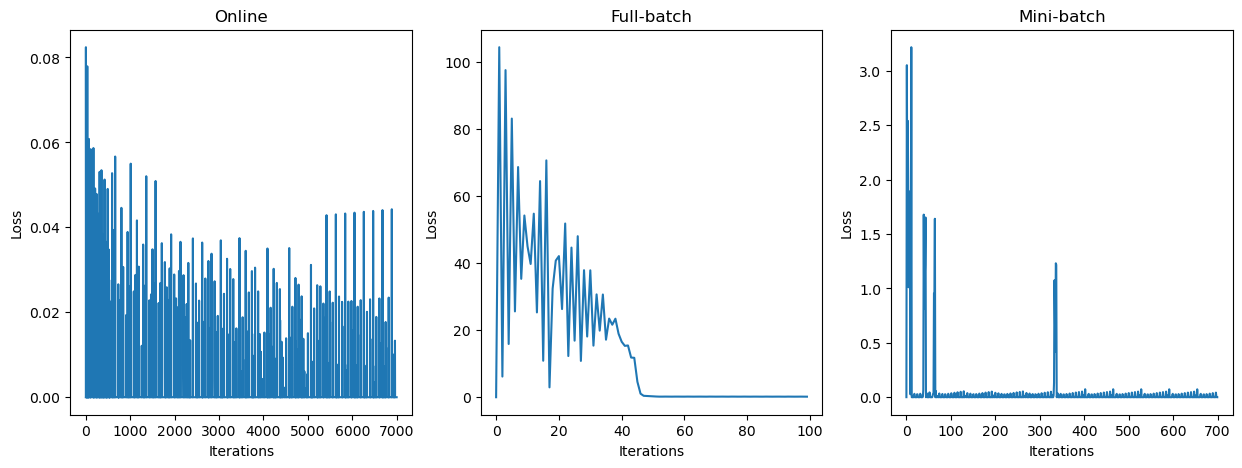

In [108]:
plt.clf()
fig = plt.figure(figsize=(15.0, 5.0))

# plot the losses
# online
ax = fig.add_subplot(1,3,1)
ax.plot(online_history['loss_history'], label='online')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Online')
# full-batch
ax = fig.add_subplot(1,3,2)
ax.plot(full_batch_history['loss_history'], label='full-batch')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Full-batch')
# mini-batch
ax = fig.add_subplot(1,3,3)
ax.plot(mini_batch_history['loss_history'], label='mini-batch')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Mini-batch');

** Question: ** In the figures above we have iterations on $x$-axis. What is an iteration and why are the quantities so different from a plot to another ? What is different from the epochs ?


*Answer on the report*

### Visualisation of accuracy

Now we will plot the accuracy of the models for each of the three types and we ask you again to describe/comment what you see.


<Figure size 1500x1000 with 0 Axes>

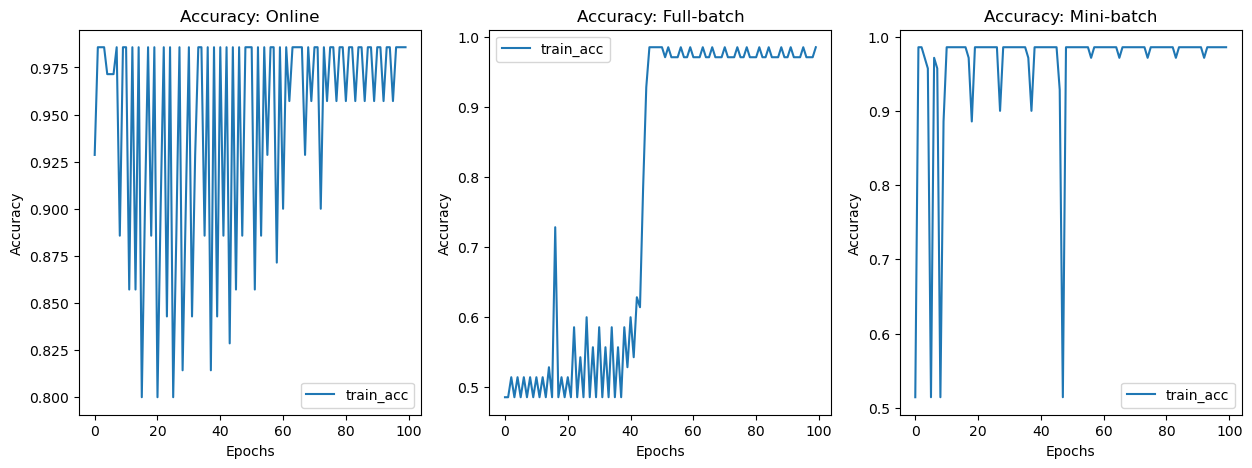

In [109]:
plt.clf()
fig = plt.figure(figsize=(15.0, 5.0))

# plot the losses
# online
ax = fig.add_subplot(1,3,1)
ax.plot(online_history['train_acc_history'], label='train_acc')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy: Online')
ax.legend()
# full-batch
ax = fig.add_subplot(1,3,2)
ax.plot(full_batch_history['train_acc_history'], label='train_acc')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy: Full-batch')
ax.legend()
# mini-batch
ax = fig.add_subplot(1,3,3)
ax.plot(mini_batch_history['train_acc_history'], label='train_acc')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy: Mini-batch')
ax.legend();

** Question: ** Comment this plots in your report ! Why are they so different ? What is according to you
the best model (full-batch, online or mini-batch) ? Explain your answer !!!

*Answer on the report*

# Testing


Once the training procedure is done and you have comment and understood what happen in the plots before, we will get the accuracy of the models for the test set. After we will plot some surfaces that we ask you to comment.

In [110]:
pred_online = online_model.predict(X_test_with_bias)

pred_full_batch = full_batch_model.predict(X_test_with_bias)

pred_mini_batch = mini_batch_model.predict(X_test_with_bias)

if pred_online is None \
    or pred_full_batch is None \
    or pred_mini_batch is None:
    print("You have to implement prediction first!")
else:
    print("The accuracy for online updates is {}%".format((y_test == pred_online.T).mean()*100.))
    print("The accuracy for full-batch updates is {}%".format((y_test == pred_full_batch.T).mean()*100.))
    print("The accuracy for mini-batch updates is {}%".format((y_test == pred_mini_batch.T).mean()*100.))

The accuracy for online updates is 100.0%
The accuracy for full-batch updates is 100.0%
The accuracy for mini-batch updates is 100.0%


As we can see, the three versions of batching have the same performance on testing set. This happen because the data is very well separated by default.

<Figure size 1500x1000 with 0 Axes>

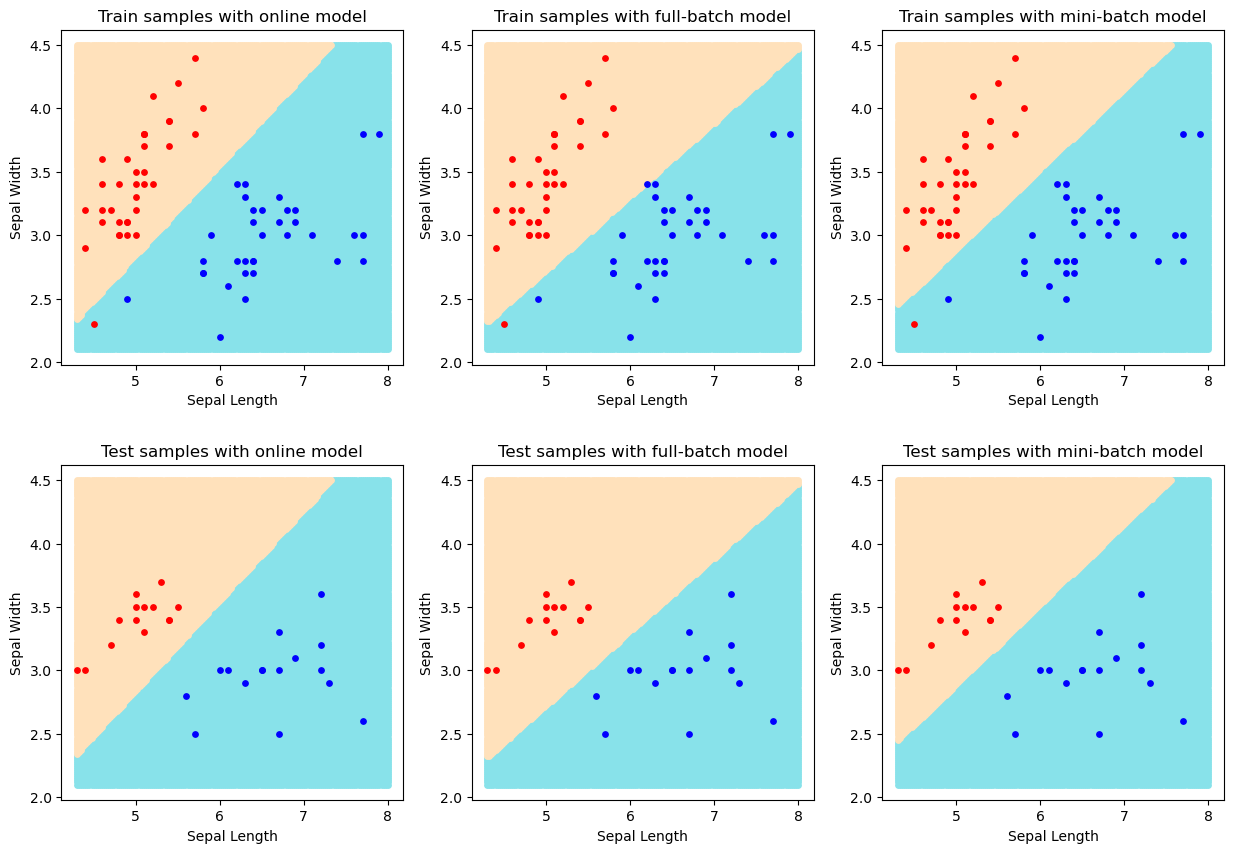

In [111]:
def get_points_surfaces(x1, y1, x2, y2):
    points_x = [x1[y1 == n_class, 0] for n_class in [-1, 1]]
    points_y = [x1[y1 == n_class, 1] for n_class in [-1, 1]]
    surfaces_x = [x2[y2[:, 0] == n_class, 0] for n_class in [-1, 1]]
    surfaces_y = [x2[y2[:, 0] == n_class, 1] for n_class in [-1, 1]]
    return points_x, points_y, surfaces_x, surfaces_y

def create_subfig(ax, points_x, points_y, surfaces_x, surfaces_y):
    for i in range(len(surfaces_x)):
        ax.scatter(surfaces_x[i], surfaces_y[i], s=15, color=colors_surfaces[i])
    for i in range(len(points_x)):   
        ax.scatter(points_x[i], points_y[i], s=15, color=colors_points[i])

n = 150

x_surf = np.zeros((n*n, 2))
tmp = np.linspace(np.min(X_train_with_bias[:, 0])-0.1, np.max(X_train_with_bias[:, 0])+0.1, n)
x_surf[:,0] = np.repeat(tmp, n)

tmp = np.linspace(np.min(X_train_with_bias[:, 1])-0.1, np.max(X_train_with_bias[:, 1])+0.1, n)
x_surf[:,1] = np.tile(tmp, n)

x_surf = np.column_stack((x_surf, np.ones(n*n)))


y_test_all = []
y_test_all.append(online_model.predict(x_surf))
y_test_all.append(full_batch_model.predict(x_surf))
y_test_all.append(mini_batch_model.predict(x_surf))

plt.rcParams['figure.figsize'] = (15., 10.)
plt.clf()
fig = plt.figure()

type_models = ['online', 'full-batch', 'mini-batch']
for idx_y in range(len(y_test_all)):
    # training samples
    ax = fig.add_subplot(2,3,1+idx_y)
    ax.set_title("Train samples with {} model".format(type_models[idx_y]))
    ax.set_xlabel(axes_labels[attribut_1])
    ax.set_ylabel(axes_labels[attribut_2])
    points_x, points_y, surfaces_x, surfaces_y = get_points_surfaces(X_train_with_bias, y_train,
                                                                     x_surf, y_test_all[idx_y])
    create_subfig(ax, points_x, points_y, surfaces_x, surfaces_y)
    
    # test samples
    ax = fig.add_subplot(2,3,4+idx_y)
    ax.set_title("Test samples with {} model".format(type_models[idx_y]))
    ax.set_xlabel(axes_labels[attribut_1])
    ax.set_ylabel(axes_labels[attribut_2])
    points_x, points_y, surfaces_x, surfaces_y = get_points_surfaces(X_test_with_bias, y_test,
                                                                     x_surf, y_test_all[idx_y])
    create_subfig(ax, points_x, points_y, surfaces_x, surfaces_y)
    
    # add space between the two lines of plots
    plt.subplots_adjust(hspace=0.3)

** Question: ** Comment this plots in your report ! What are the surfaces ? What is the line between the surfaces? What are the bullets points ? What are the colors for?


In [112]:
online_model.params['W']

array([[-0.10245479],
       [ 0.14392949],
       [ 0.10404943]])

# Non separable problem

Before we train our models for a well separated problem and perceptron works very well. Here we will train and visualize the loss of a non separable problem.

<Figure size 1500x1000 with 0 Axes>

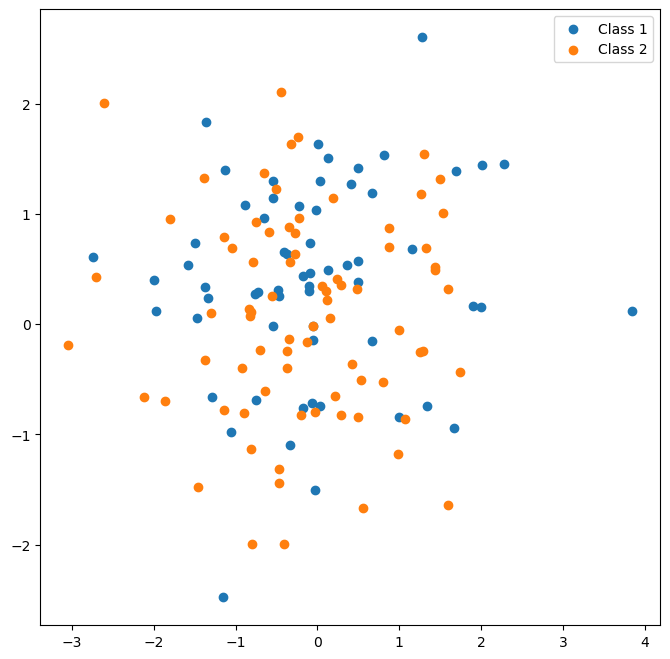

In [113]:
# number of samples
n = 200
# percentage of training samples
p = 0.7

np.random.seed(132)
# generate non-separable samples
x_train_ns = np.column_stack((np.random.randn(int(n*p),2), np.ones(int(n*p))))
x_test_ns = np.column_stack((np.random.randn(int(n*(1-p)),2), np.ones(int(n*(1-p)))))

y_train_ns = np.random.choice([-1, 1], int(n*p))
y_test_ns = np.random.choice([-1, 1], int(n*(1-p)))

# show data
plt.clf()
fig = plt.figure(figsize=(8.0, 8.0))
plt.scatter(x_train_ns[y_train_ns== 1,0], x_train_ns[y_train_ns == 1,1], label='Class 1')
plt.scatter(x_train_ns[y_train_ns== -1,0], x_train_ns[y_train_ns == -1,1], label='Class 2')
plt.legend()

Now we will train again our three models and visualize the evolution of loss. 

<Figure size 1500x1000 with 0 Axes>

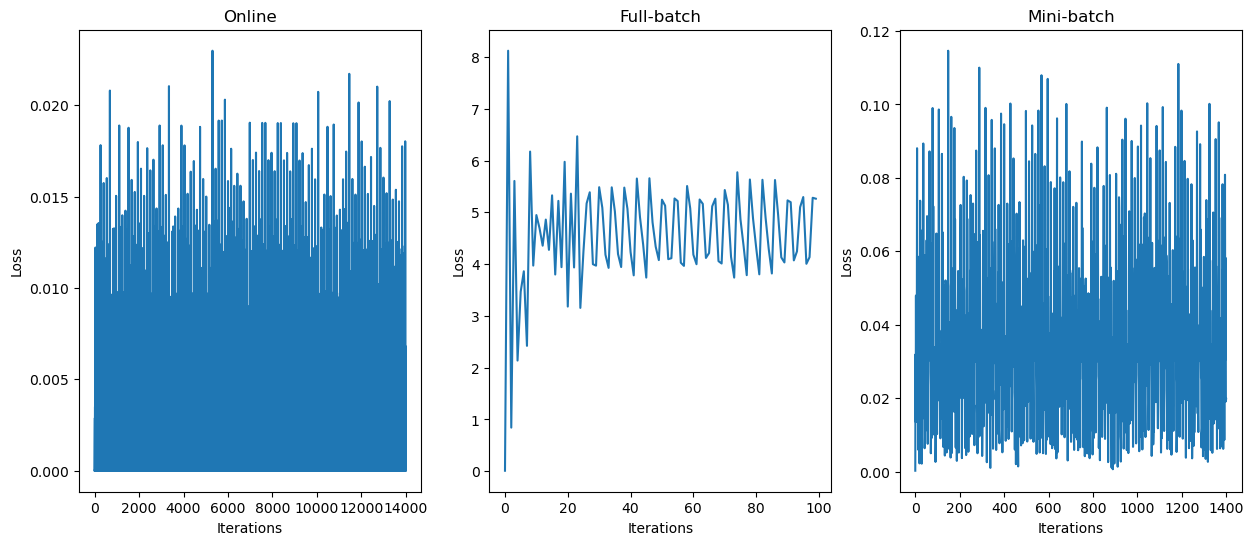

In [114]:
n_epochs = 100
D = 3

# initialise and tain model with online batching
np.random.seed(132)
online_model = perceptron(D)
online_history = online_model.train(x_train_ns, y_train_ns,
                                    num_epochs=n_epochs, batch_size=1)

# initialise and tain model with full-batch 
np.random.seed(132)
full_batch_model = perceptron(D)
full_batch_history = full_batch_model.train(x_train_ns, y_train_ns,
                                            num_epochs=n_epochs, batch_size=int(n*p))

# initialise and tain model with mini-batch
np.random.seed(132)
mini_batch_model = perceptron(D)
mini_batch_history = mini_batch_model.train(x_train_ns, y_train_ns,
                                            num_epochs=n_epochs, batch_size=10)


plt.clf()
fig = plt.figure(figsize=(15.0, 6.0))

# plot the losses
# online
ax = fig.add_subplot(1,3,1)
ax.plot(online_history['loss_history'], label='online')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Online')
# full-batch
ax = fig.add_subplot(1,3,2)
ax.plot(full_batch_history['loss_history'], label='full-batch')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Full-batch')
# mini-batch
ax = fig.add_subplot(1,3,3)
ax.plot(mini_batch_history['loss_history'], label='mini-batch')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Mini-batch');

** Question:** What can you say about the losses of the three perceptrons we visualize above?